In [124]:
"""All the import needed !"""

import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn

In [125]:
"""" ALL THE CONSTANT """
EPSILON = 0.3

In [126]:
"""Load the training dataset """
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        '.',
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.1307), std=(0.3081))
        ])),
    100,
    shuffle=True
)

In [127]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, outputs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        self.nn = nn.Sequential(
            nn.Linear(320, 128),
            nn.ReLU(),
            nn.Linear(128, outputs)
        )

    def forward(self, x):
        return self.nn(self.conv(x))

net = NeuralNetwork(outputs=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=net.parameters(), lr=5e-4)

EPOCHS = 10


In [141]:
for epochs in range(EPOCHS)
    for batch_idx, (data, target) in enumerate(train_loader):
        correct = 0

        output = net.forward(data)
        pred = output.argmax(dim=1)

        optimizer.zero_grad()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        for y1, y2 in zip(pred, target):
            if y1 == y2:
                correct += 1
        print(f'Epoch {epochs} and batch index: {batch_idx} {correct}/{len(data)}\tLoss: {loss:.2f}')

Epoch 0: 91/100	Loss: 0.36
Epoch 1: 85/100	Loss: 0.48
Epoch 2: 88/100	Loss: 0.47
Epoch 3: 86/100	Loss: 0.45
Epoch 4: 87/100	Loss: 0.45
Epoch 5: 90/100	Loss: 0.38
Epoch 6: 85/100	Loss: 0.45
Epoch 7: 88/100	Loss: 0.41
Epoch 8: 94/100	Loss: 0.28
Epoch 9: 85/100	Loss: 0.50
Epoch 10: 89/100	Loss: 0.38
Epoch 11: 90/100	Loss: 0.34
Epoch 12: 90/100	Loss: 0.41
Epoch 13: 87/100	Loss: 0.35
Epoch 14: 89/100	Loss: 0.40
Epoch 15: 86/100	Loss: 0.62
Epoch 16: 85/100	Loss: 0.39
Epoch 17: 89/100	Loss: 0.47
Epoch 18: 84/100	Loss: 0.45
Epoch 19: 90/100	Loss: 0.40
Epoch 20: 83/100	Loss: 0.55
Epoch 21: 84/100	Loss: 0.52
Epoch 22: 80/100	Loss: 0.66
Epoch 23: 84/100	Loss: 0.52
Epoch 24: 90/100	Loss: 0.35
Epoch 25: 85/100	Loss: 0.48
Epoch 26: 86/100	Loss: 0.50
Epoch 27: 89/100	Loss: 0.39
Epoch 28: 90/100	Loss: 0.36
Epoch 29: 84/100	Loss: 0.55
Epoch 30: 88/100	Loss: 0.40
Epoch 31: 88/100	Loss: 0.39
Epoch 32: 91/100	Loss: 0.33
Epoch 33: 85/100	Loss: 0.49
Epoch 34: 94/100	Loss: 0.37
Epoch 35: 90/100	Loss: 0.35
Ep

tensor(0)


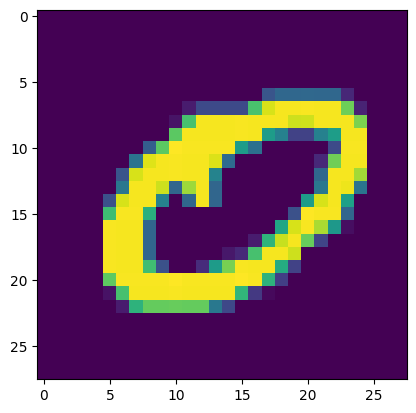

In [147]:
def test_image_N(train_loader, net, n):
    image = next(enumerate(train_loader))[1][0][0]
    plt.imshow(image.reshape((28, 28)))
    pred = net.nn(torch.flatten(net.conv(image)))
    return pred.argmax()
print(test_image_N(train_loader, net, 0))

In [188]:
"""Load the testing dataset """

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        '.',
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.1307), std=(0.3081))
        ])),
  batch_size=1,
  shuffle=True
)

In [189]:
def fast_gradient_sign_method(model: NeuralNetwork, image: torch.Tensor, gradient, epsilon: float):
    """ That's the main function for white box adversarial attack """
    sign_grad = gradient.sign()
    perturbed_image = image + epsilon * sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [193]:
"""View ==> Format data"""
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """ Restores the tensors to their original scale"""
    if isinstance(mean, list):
        mean = torch.tensor(mean)
    if isinstance(std, list):
        std = torch.tensor(std)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [198]:
def fgsm_attack(model: NeuralNetwork, test_loader, epsilon: float):
    """ Compute all the adversarial attack !!! """
    correct = 0
    adv_examples = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data.requires_grad = True

        output = net.forward(data)
        predicted_nbr = output.argmax(dim=1)
        if predicted_nbr != target.item():
            continue

        loss = loss_fn(output, target)
        net.zero_grad()
        loss.backward()

        data_grad = data.grad.data

        data_denorm =  denorm(data)

        perturbed_data = fast_gradient_sign_method(model=model, image=data_denorm, gradient=data_grad, epsilon=epsilon)

        perturbed_data_normalized = torchvision.transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = net.forward(perturbed_data_normalized)
        final_predict = output.argmax().item()
        if final_predict == target.item():
            correct += 1
        else:
            if len(adv_examples) < 5:
                adv_examples.append((predicted_nbr, final_predict, perturbed_data))

    acc = correct / float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {acc}")
    return acc, adv_examples

In [199]:
list_examples = []
list_accuracies = []

all_epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

"""Execute the attacks !!"""
for eps in all_epsilons:
    final_acc, adv_examples = fgsm_attack(net, test_loader, eps)
    list_examples.append(adv_examples)
    list_accuracies.append(final_acc)

Epsilon: 0.0	Test Accuracy = 8874 / 10000 = 0.8874
Epsilon: 0.05	Test Accuracy = 7560 / 10000 = 0.756
Epsilon: 0.1	Test Accuracy = 5786 / 10000 = 0.5786
Epsilon: 0.15	Test Accuracy = 3945 / 10000 = 0.3945
Epsilon: 0.2	Test Accuracy = 2239 / 10000 = 0.2239
Epsilon: 0.25	Test Accuracy = 776 / 10000 = 0.0776
Epsilon: 0.3	Test Accuracy = 207 / 10000 = 0.0207


tensor(5)

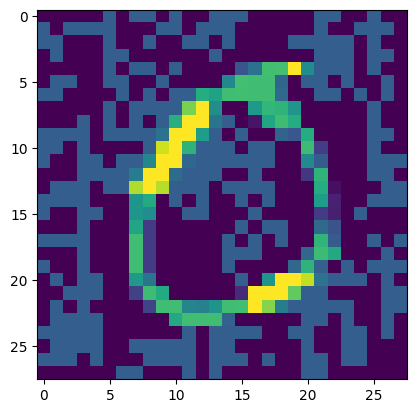

In [204]:
""" Test examples """
plt.imshow(adv_examples[3][2].detach().numpy().reshape((28, 28)))
pred = net.nn(torch.flatten(net.conv(adv_examples[3][2])))
pred.argmax()